# Extracting MFCC Features from Pathological dataset 2

## Step 1: Load the audio file

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import fft, dct, fftshift
import matplotlib.pyplot as plt 
from scipy import signal
import librosa
import librosa.display

In [2]:
def plotAudio(audio, sample_rate):
    plt.figure(figsize=(17,5))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    plt.grid(True)

In [3]:
def loadAudioFile(filename):
    fs, audioInput = scipy.io.wavfile.read(filename)
    print("Sample rate: {0} Hz".format(fs))
    print("Audio duration: {0} sec".format(len(audioInput) / fs))
    return audioInput, fs

/usr/local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Sample rate: 44100 Hz
Audio duration: 1.2073242630385488 sec
Frame Size: 882.0 samples
Overlap: 441.0 samples
53243


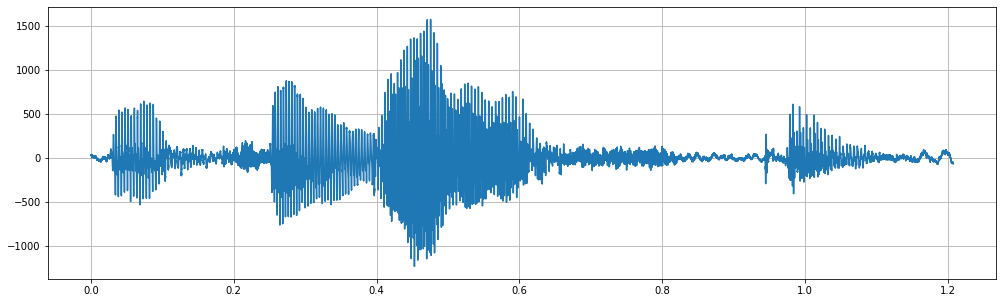

In [10]:
filename = '../../data/Patients/P10/07_VSL/4sja7mat.wav'
audioInput, fs = loadAudioFile(filename)
frameSize = 0.020*fs
overlap = (frameSize/2)
print("Frame Size: {0} samples".format(frameSize))
print("Overlap: {0} samples".format(overlap))
print(len(audioInput))
plotAudio(audioInput, fs)

## Step 2: Pre-emphasis
y(t)=x(t)−αx(t−1)

In [11]:
def preemphasis(audioInput):
    alpha = 0.95
    emphasized_audio = np.append(audioInput[0], audioInput[1:] - alpha * audioInput[:-1])
    return emphasized_audio

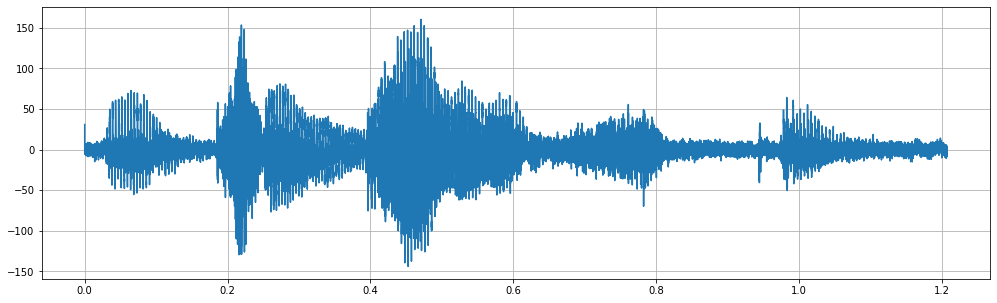

In [12]:
emphasized_audio = preemphasis(audioInput)
plotAudio(emphasized_audio, fs)

## Step 3: Frame Blocking

In [26]:
def frameBlocking(audio, frameSize, overlap):
    frameSize = int(frameSize)
    overlap = int(overlap)
    num_frames = int(np.ceil(len(audio)/(frameSize - overlap))) 
    print("Number of frames: ", num_frames)

    padding = ((frameSize-overlap)*num_frames) - len(audio) 
    zeros = np.zeros((padding))
    audio = np.append(audio, zeros) 
    
    frames = np.empty((frameSize, num_frames)) 
    start = 0
    for i in range(num_frames):
        frames[:,i] = audio[start:start + frameSize]
        start = (frameSize-overlap)*i 
        
    frames = frames.T
    
    return frames

In [27]:
frames = frameBlocking(emphasized_audio, frameSize, overlap)
print(frames.shape)

Number of frames:  121
(121, 882)


## Step 4: Windowing

In [28]:
def applyWindow(frames):
    originalFrame = frames[50]
    
    window = np.hamming(frameSize)
    windowed_frames = frames * window
    windowedFrame = windowed_frames[50]
    
    plt.figure(figsize=(13,5))
    
    plt.subplot(2, 1, 1)
    plt.plot(originalFrame)
    plt.title('Original Frame')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(windowedFrame)
    plt.title('Frame after Windowing')
    plt.grid(True)
    
    return frames

(121, 882)


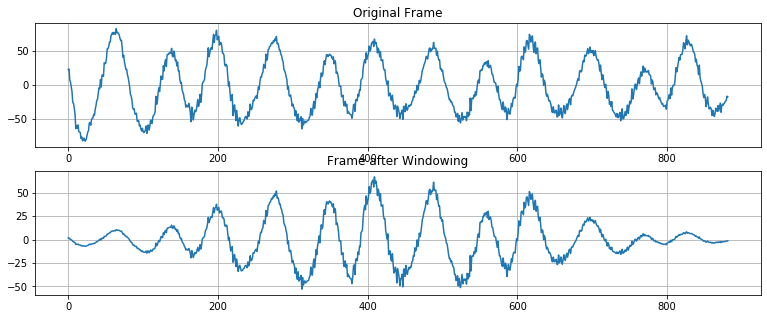

In [29]:
windowed_frames = applyWindow(frames)
print(windowed_frames.shape)

## Step 5: FFT and Periodogram

In [30]:
def findPeriodogram(windowed_frames, frameSize):
    audio_fft = np.absolute(fft(windowed_frames,nfft))
    audio_fft = audio_fft[:,:nfft//2+1]

    periodogram = ((1.0 / nfft) * ((audio_fft) ** 2))
    print(periodogram.shape)
    
    return periodogram

In [31]:
nfft = 512;
periodogram = findPeriodogram(windowed_frames, frameSize)

(121, 257)


In [32]:
# print(periodogram[0])

## Step 6: Filter Banks and Filtering the signal

The power spectrum(periodogram) has been computed using the following equation:

P = (|FFT(xi)|^2 ) / N

In [35]:
def createMelFilterBank(numFilters, nfft, fs):
    fmin_mel = 0
    fmax_mel = (2595 * np.log10(1 + (fs // 2) / 700))
    print("Min mel-frequency: {0}".format(fmin_mel))
    print("Max mel-frequency: {0}".format(fmax_mel))
    
    mel = np.linspace(fmin_mel, fmax_mel, numFilters+2)
    hertz = (700 * (10**(mel / 2595) - 1))
    fbins = np.floor((nfft + 1) * hertz / fs)
    fbank = np.zeros((nfft//2+1, numFilters))
    
    for i in range(1,numFilters+1):
        for k in range(int(nfft//2 + 1)):
            if k < fbins[i-1]:
                fbank[k, i-1] = 0
            elif k >= fbins[i-1] and k < fbins[i]:
                fbank[k,i-1] = (k - fbins[i-1])/(fbins[i] - fbins[i-1])
            elif k >= fbins[i] and k < fbins[i+1]:
                fbank[k,i-1] = (fbins[i+1] - k)/(fbins[i+1] - fbins[i])
            else:
                fbank[k,i-1] = 0
    
    return fbank, mel

In [36]:
numFilters = 12
fbank, mel_freqs = createMelFilterBank(numFilters, nfft, fs) 
print(fbank.shape)

Min mel-frequency: 0
Max mel-frequency: 3923.337321740179
(257, 12)


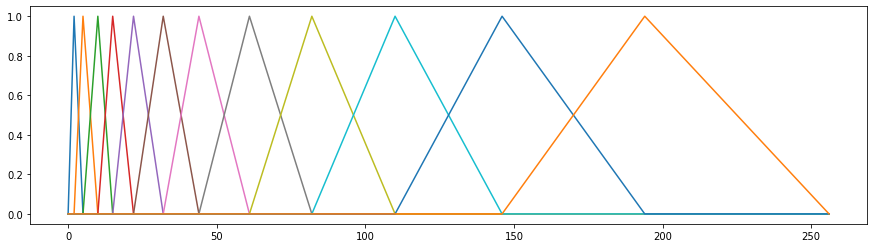

In [38]:
plt.figure(figsize=(15,4))
for n in range(fbank.T.shape[0]):
    plt.plot(fbank.T[n])

In [79]:
def filtering(periodogram, fbank):    
    melFiltered = np.log10(np.dot(periodogram, fbank))
    librosa.display.specshow(melFiltered,  x_axis='frames', y_axis='mel')
    plt.title('Spectrogram of mel filtered signal')
    plt.colorbar(format='%+2.0f')
    plt.tight_layout()
    return melFiltered

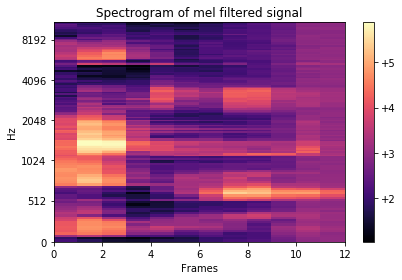

In [80]:
melFiltered = filtering(periodogram, fbank)

## Step 7: Mel-frequency Cepstral Coefficients (MFCCs)

In [83]:
def findMFCC(melFiltered):
    mel_coeff = dct(melFiltered, type=3)
    plt.title("MFCC")
    librosa.display.specshow(mel_coeff,  x_axis='frames', y_axis='mel')
    return mel_coeff 

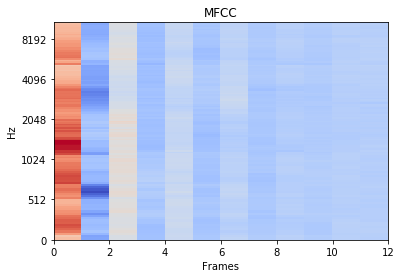

In [84]:
mfcc = findMFCC(melFiltered)

In [81]:
def meanNormalisation(mfcc):    
    norm_mfcc = mfcc - (np.mean(mfcc, axis=0) + 1e-8)
    plt.title("mean normalised MFCC")
    librosa.display.specshow(norm_mfcc, x_axis='frames', y_axis='mel')
    return norm_mfcc

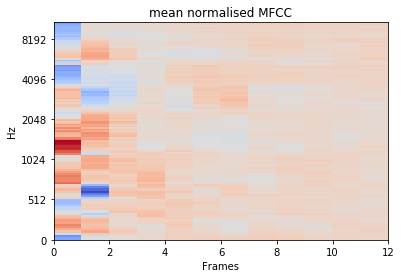

In [82]:
mean_normalized_mfcc = meanNormalisation(mfcc)